## Overview 

The project at hand involves the analysis of data from the English Premier League, where each row within the dataset comprises match statistics for a specific team, accompanied by relevant metadata. Our primary objective is the development of a prediction model that can serve as a pre-match statistical tool or as a metric for sports betting.

### Project Objective

**The central aim of this project is to predict the outcome of a football match for a particular team.   
This prediction will be contingent upon the team's recent performance and the prevailing playing conditions.** 


In [174]:
import pandas as pd
import numpy as np 
import sklearn 
import pickle 
import os

import sys

sys.path.append('../../src/features')

import build_features

import warnings 
warnings.filterwarnings('ignore')


matches = pd.read_csv('../../data/raw/matches.csv')
matches.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
1,2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
2,3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
3,4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
4,6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


## EDA - Insights & Actionables

### Columns

Upon initial inspection of the dataset, several columns have been identified as uninformative and will be dropped from the analysis. These columns include:
- `formation`
- `Unnames: 0`
- `comp`
- `day`
- `round`
- `match report`
- `notes`
- `referee`
- `captain`

### Datatypes

#### Date and Time Columns

The dataset contains separate date and time columns, both currently stored as object data types. To improve data consistency and analysis, we will create a new datetime column and convert the date and time columns into datetime format.

#### Categorical Columns

Certain categorical columns, such as `venue`, `day`, `formation`, and `result`, need to be represented in a numeric format for further analysis.

### Feature Engineering

#### Rolling Averages

To enhance our predictive modeling capabilities, we will compute rolling averages for the last 3 months (or a suitable time window) for the following features:
- `ga` (goals against)
- `gf` (goals for)
- `sot` (shots on target)
- `sh` (total shots attempted)
- `dist` (distance covered)
- `fk` (free kicks)
- `pk` (penalty kicks)
- `pkatt` (penalty kicks attempted)
- `xg` (expected goals)
- `xga` (expected goals against)

#### Derived Columns

We will create two derived columns:
1. `pkr` (Penalty Kick Ratio): This column will represent the ratio of penalty kicks converted to the total number of penalty kicks attempted. It can provide insights into a team's proficiency in converting penalties.
2. `skr` (Shots on Target Ratio): This column will indicate the proportion of shots on target relative to the total number of shots attempted. It can serve as a measure of a team's accuracy in hitting the target.

These engineered features and derived columns will contribute to a more robust and informative dataset for subsequent analysis and modeling.



In [175]:

DataCleaner = build_features.CleanDataset(matches)
cleaned_data = DataCleaner.main()
DataTransformer = build_features.FeatureAddition(cleaned_data)
matches_processed = DataTransformer.main()
matches_processed.head()

,date,time,day,venue,result,opponent,poss,formation,season,team,...,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling,xg_rolling,xga_rolling,pkr,skr,target
0,2020-10-04,14:00:00,3,1,2,Sheffield Utd,63.0,10,2021,Arsenal,...,3.666667,14.733333,0.666667,0.000000,0.000000,1.466667,1.766667,NaN,0.478261,0
1,2020-10-17,17:30:00,2,0,1,Manchester City,41.0,1,2021,Arsenal,...,3.666667,15.766667,0.000000,0.000000,0.000000,1.000000,1.766667,NaN,0.687500,1
2,2020-10-25,19:15:00,3,1,1,Leicester City,57.0,1,2021,Arsenal,...,3.666667,16.733333,0.666667,0.000000,0.000000,0.833333,1.633333,NaN,0.523810,1
3,2020-11-01,16:30:00,3,0,2,Manchester Utd,47.0,1,2021,Arsenal,...,4.000000,16.033333,1.000000,0.000000,0.000000,0.733333,0.966667,NaN,0.413793,0
4,2020-11-08,19:15:00,3,1,1,Aston Villa,58.0,1,2021,Arsenal,...,2.666667,18.033333,1.000000,0.333333,0.333333,0.966667,1.000000,1.0,0.275862,1


## Choosing Predictors & Target

### Target Variable

In our endeavor to predict the outcome of a football match, we must first define our target variable. Upon inspecting the distribution of results in the dataset, we observe that over 70% of the data corresponds to either a loss or a draw. This significant prevalence of non-winning outcomes suggests that training a model to predict a loss or a draw for the team may yield more meaningful results. Therefore, we will frame this prediction task as a binary classification problem:
- Label 1 represents "not-a-win" (i.e., a draw or a loss).
- Label 0 represents a win.

### Predictor Variables

The following predictor variables have been selected for our model:
- `venue`: The venue where the match is played is a crucial factor in predicting the outcome. Playing in a home environment tends to be more favorable for a team, while away games can be challenging.
- `formation`: The choice of formation can significantly impact a team's performance. Certain formations work better for specific teams, while others may not be as effective.
- `hour`: The time of the match can influence the outcome. Different conditions during day and night matches may affect team performance.
- `opp_code`: The opponent code is an essential predictor as it pairs well with the formation and considers the team's historical performance against a particular opponent.
- `gf_rolling`, `ga_rolling`, `fk_rolling`, `pk_rolling`, `skr`: These rolling average statistics provide insights into the team's recent form. Goals scored (gf) and goals conceded (ga) reflect offensive and defensive performance, while free kicks (fk) and penalty kicks (pk) can be decisive moments in a match. The 'skr' column, representing the shots on target ratio, measures the team's accuracy in hitting the target.

#### Rationale for Predictor Selection

The selection of these predictors is grounded in domain knowledge and their significance in predicting match outcomes:
- `venue` accounts for the home advantage factor.
- `formation` acknowledges the tactical aspect of football.
- `hour` considers match conditions, which can vary during day and night.
- `opp_code` captures historical performance dynamics against specific opponents.
- `gf_rolling`, `ga_rolling`, `fk_rolling`, `pk_rolling`, and `skr` reflect recent team form, encompassing offensive and defensive aspects.

### Dropping Columns

To mitigate multicollinearity and maintain the model's interpretability, certain columns were dropped.  
 The selected columns represent the most relevant statistics for predicting match outcomes based on our domain knowledge.



In [176]:

predictors = matches_processed[['venue', 'formation', 'hour', 'opp_code', 'gf_rolling', 'ga_rolling','fk_rolling', 'pk_rolling', 'skr']]

scaled_predictors = build_features.standardize_data(predictors)

target = pd.DataFrame(matches_processed['target'])

## Model Building

In this section, we outline the steps involved in building the predictive model for football match outcomes.

### 1. Defining Train & Test Sets

The first step in model building is to define the training and test datasets. The dataset is typically split into two parts:
- Training Set: This portion of the data is used to train the model, allowing it to learn patterns and relationships in the data.
- Test Set: The test set is used to evaluate the model's performance on unseen data. It helps assess how well the model generalizes to new observations.

### 2. Model Selection

Selecting an appropriate model architecture is a crucial decision in the modeling process. Various machine learning algorithms can be considered, including but not limited to:
- Logistic Regression
- Random Forest
- Gradient Boosting


### 3. Model Optimization

After choosing a model, the next step is to optimize its hyperparameters. Hyperparameters are settings that influence a model's behavior but are not learned from the data. Optimization techniques such as grid search or random search can be employed to find the best combination of hyperparameters that maximize model performance.

### 4. The Final Model

Once the model is trained and optimized, it becomes the final model used for making predictions. The final model should be evaluated rigorously using appropriate performance metrics to ensure it meets the desired accuracy and generalization requirements.

The subsequent sections will delve into each of these steps in more detail, providing insights into the model selection process, hyperparameter tuning, and the evaluation of the final model's performance.


### Defining Train & Test Sets

In the context of our analysis, we are dealing with time series data. Therefore, it is imperative to carefully define our training and testing sets to ensure that we do not inadvertently use future data to predict past outcomes. Unlike random splits commonly used in cross-sectional data, for time series data, we are manually defining the train and test sets.

#### Train Set

The training set comprises all matches played before the year 2022. This choice ensures that our model learns from historical data leading up to, but not including, the year 2022. By doing so, we aim to capture patterns and relationships present in the data up to that point.

#### Test Set

Conversely, the test set consists of all matches played in the year 2022. This delineation allows us to evaluate our model's performance on data it has not seen during training. Testing on data from 2022 serves as a realistic simulation of real-world predictions, where the model must make forecasts for upcoming matches based on past information.



In [177]:
scaled_predictors['Year'] =  matches_processed.datetime.dt.year
target['Year'] =      matches_processed.datetime.dt.year

# Training Set 

X_train =  scaled_predictors[scaled_predictors.Year < 2022].drop('Year', axis = 1)
Y_train =  target[target.Year < 2022].drop('Year', axis = 1)


# Test Set 

X_test = scaled_predictors[scaled_predictors.Year == 2022].drop('Year', axis = 1)
Y_test = target[target.Year == 2022].drop('Year', axis = 1)


scaled_predictors.drop('Year', axis=1, inplace=True)
target.drop('Year', axis=1, inplace=True)


### Model Selection

In this phase of our analysis, we aim to select the most suitable model for predicting football match outcomes. Given that we are working with time series data, we will employ time series cross-validation to make informed decisions about model performance.

#### Candidate Models

We have identified three candidate models for our prediction task:
- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier

These models represent a diverse range of algorithms, and we will evaluate their performance to determine which one best suits our predictive needs.

#### Time Series Cross-Validation

To assess the models effectively on time series data, we will employ time series cross-validation. This approach differs from traditional cross-validation because it respects the temporal order of the data. Our choice is to use a time series split, which involves splitting the data into multiple consecutive time-based folds.

#### Number of Folds

We will use a time series split with 3 folds. This choice ensures that each fold contains a sufficient amount of data, allowing our models to learn from diverse time periods while maintaining a robust validation process.

#### Scoring Metric

The scoring metric for model evaluation will be the `precision_score`. Precision is a crucial metric for our task since we will be making per-match predictions. We want to optimize the chances of our model being correct when it makes a prediction. Precision focuses on the accuracy of positive predictions and is well-suited for scenarios where false positives are undesirable.



In [178]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score


X = X_train
y = Y_train


# Number of folds for time series cross-validation
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'XGBoost': XGBClassifier(random_state= 42),
    'Random Forest': RandomForestClassifier(random_state= 42)
}

# Dictionary to store cross-validation results
cv_results = {}

# Loop through the models and perform cross-validation
for model_name, model in models.items():
    precision_scores = []  # To store precision scores for each fold
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        
        # Calculate precision and store it
        precision = precision_score(y_test, y_pred)
        precision_scores.append(precision)
    
      # Store the average precision and median precision for this model
    cv_results[model_name] = {
        'Average Precision': np.mean(precision_scores),
        'Median Precision': np.median(precision_scores)
    }

# Print the cross-validation results
for model_name, scores in cv_results.items():
    print(f'{model_name}:')
    print(f'Average Precision = {scores["Average Precision"]:.4f}')
    print(f'Median Precision = {scores["Median Precision"]:.4f}')
    print()

Logistic Regression:
Average Precision = 0.6206
Median Precision = 0.6525

XGBoost:
Average Precision = 0.6219
Median Precision = 0.6404

Random Forest:
Average Precision = 0.6297
Median Precision = 0.6530



**Selected Model: Random Forest Classifier** 

## Model Optimization

In this phase of our analysis, we focus on improving the model's performance by tuning its hyperparameters. To achieve this, we will utilize `GridSearchCV`, a powerful technique for systematically searching and selecting the best hyperparameter combinations.

### Hyperparameter Tuning

The primary goal of hyperparameter tuning is to enhance the cross-validation precision score of our model. A higher precision score indicates that our model is making more accurate positive predictions, which is crucial for our per-match outcome predictions.

#### Time Series Cross-Validation

As we are dealing with time series data, it is essential to account for the temporal nature of our dataset during hyperparameter tuning. To achieve this, we will utilize the `TimeSeriesSplit` method as the cross-validation (CV) strategy within `GridSearchCV`.

#### TimeSeriesSplit in CV

`TimeSeriesSplit` is a specialized cross-validation method tailored for time series data. It ensures that the training and testing sets in each fold respect the chronological order of the data. This approach is essential for maintaining the integrity of our time-based predictions.

By incorporating `TimeSeriesSplit` into the `cv` parameter of `GridSearchCV`, we ensure that our hyperparameter tuning process accounts for the time-dependent patterns present in our football match dataset.



In [179]:

scaled_predictors['Year'] =  matches_processed.datetime.dt.year
target['Year'] =      matches_processed.datetime.dt.year

# Training Set 

X_train =  scaled_predictors[scaled_predictors.Year < 2022].drop('Year', axis = 1)
Y_train =  target[target.Year < 2022].drop('Year', axis = 1)


# Test Set 

X_test = scaled_predictors[scaled_predictors.Year == 2022].drop('Year', axis = 1)
Y_test = target[target.Year == 2022].drop('Year', axis = 1)


scaled_predictors.drop('Year', axis=1, inplace=True)
target.drop('Year', axis=1, inplace=True)


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

X = X_train
y = Y_train

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters to search through
param_grid = {
    'max_depth': [None],
    'min_samples_split': [5,7,9, 10],
    'min_samples_leaf': [3, 5, 7, 9],
    'random_state' : [0, 42, 749]
}

# Create a GridSearchCV object with precision as the scoring metric
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring='precision', cv=TimeSeriesSplit(n_splits=3))

# Fit the GridSearchCV to your data
grid_search.fit(X, y)

# Get the best estimator and its associated precision score
best_rf_estimator = grid_search.best_estimator_
best_precision_score = grid_search.best_score_

# Print the best hyperparameters and precision score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Precision Score:", best_precision_score)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'random_state': 749}
Best Precision Score: 0.6360573160007986


### The Final Model

Now that we have determined the optimal hyperparameters using `GridSearchCV`, we are ready to proceed with training the final model.  
This model will be built with the best estimator, ensuring that it incorporates the most effective hyperparameter settings.


In [180]:
Model = best_rf_estimator
Model.fit(X_train, Y_train)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=5,
                       random_state=749)

## Model Diagnostics & Evaluation

In this phase, we aim to comprehensively assess our model's performance and determine the optimal threshold.  
Our objective is to strike a balance between Precision and Recall, optimizing model performance.


#### Initial Classification Metrics with Threshold of 0.5

In [181]:
predictions = Model.predict(X_test)
from sklearn.metrics import  precision_score, recall_score, f1_score

precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

# Create a DataFrame
initial_classification_metrics = pd.DataFrame({
    'Metric': ['Precision Score', 'Recall Score', 'F1 Score'],
    'Value': [precision, recall, f1]
})

initial_classification_metrics

,Metric,Value
0,Precision Score,0.671053
1,Recall Score,0.874286
2,F1 Score,0.759305


###  PR Curve Analysis

The precision metric currently shows room for improvement while striving to maintain recall.   
To explore potential enhancements, we will analyze the precision-recall (PR) curve and investigate whether an optimal threshold can be identified.


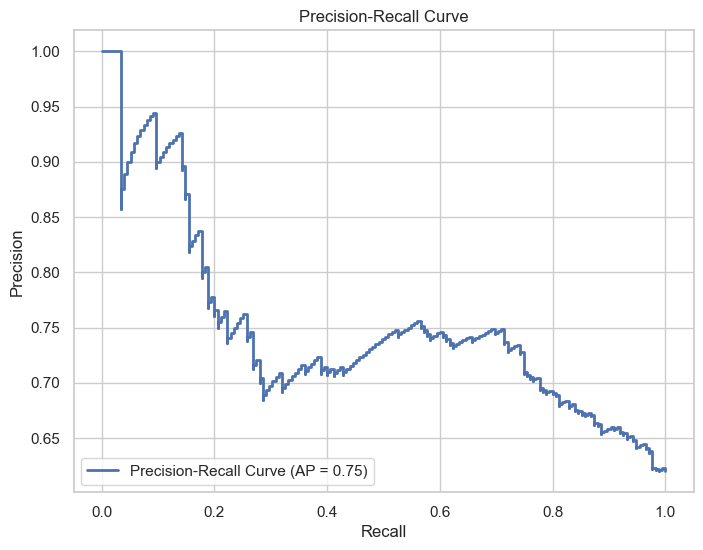

In [182]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

# Assuming you have already defined Model, X_test, and Y_test

# Calculate predictions from the model
predictions = Model.predict(X_test)


# Customize the plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(style="whitegrid")  # Set Seaborn theme

# Plot the Precision-Recall curve without borderlines
precision_recall_display.plot(ax=ax, name="Precision-Recall Curve", lw=2)

# Label the graph and axes
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Show the plot
plt.legend(loc='lower left')
plt.show()


### Insights from PR Curve Analysis

Upon examination of the precision-recall (PR) curve, we observe that we are currently operating with a recall above 0.8 and a precision around 0.65. By analyzing the graph, we discern that shifting to the left on the curve may lead to a threshold value where precision reaches approximately 0.75, while maintaining a recall of around 0.7. This balance between precision and recall appears favorable.

To achieve this optimal balance, we will utilize Youden's J statistic method in the hope of identifying the threshold value that aligns with these performance criteria.

### Youden's J Statistic Analysis

Youden's J statistic is a critical metric in binary classification that helps strike a balance between correctly identifying positive cases (recall) and correctly identifying negative cases (specificity). It quantifies model performance on a scale from 0 to 1, where higher values signify better overall performance. Maximizing Youden's J statistic enables us to identify the optimal threshold, achieving the best classification performance while minimizing both false positives and false negatives.


In [183]:
import numpy as np
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test.target.tolist(), [p[1] for p in Model.predict_proba(X_test)] )

youden_j_values = tpr - fpr
best_threshold_index = np.argmax(youden_j_values)
best_threshold = thresholds[best_threshold_index]
best_youden_j = youden_j_values[best_threshold_index]

print("Best Threshold:", best_threshold)
print("Max Youden's J Statistic:", best_youden_j)

Best Threshold: 0.6021120399638202
Max Youden's J Statistic: 0.321762349799733


### Insights from the Analysis

After conducting the analysis, we have identified the following key findings:

- **Best Threshold:** 0.602
- **Max Youden's J Statistic:** 0.321


####  Classification Metrics Post Threshold Optimization 



In [184]:
predictions_v2 = [1 if (x[1] > 0.602) else 0 for x in Model.predict_proba(X_test)]

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already calculated predictions_v2 and have ground truth labels in Y_test

precision = precision_score(Y_test, predictions_v2)
recall = recall_score(Y_test, predictions_v2)
f1 = f1_score(Y_test, predictions_v2)

# Create a DataFrame
metrics_post_optimization = pd.DataFrame({
    'Metric': ['Precision Score', 'Recall Score', 'F1 Score'],
    'Value': [precision, recall, f1]
})



metrics_post_optimization


,Metric,Value
0,Precision Score,0.748503
1,Recall Score,0.714286
2,F1 Score,0.730994


By employing Youden's J Statistic, we have identified the optimal threshold point, effectively achieving a favorable balance between precision and recall in our model.

## Model Interpretation & Usage

### Model Details

Our predictive model is a **Random Forest Classifier** with the following parameters:
- `max_depth`: None
- `min_samples_leaf`: 5
- `min_samples_split`: 5
- `random_state`: 749

### Threshold and Performance Metrics

We utilize a threshold value of **0.62** to make predictions, resulting in the following performance metrics:

#### Model Performance Metrics
| Metric          | Score     |
|-----------------|-----------|
| Precision Score | 0.748503  |
| Recall Score    | 0.714286  |
| F1 Score        | 0.730994  |


### Interpretation

An F1 score of 0.73 indicates a fair balance between precision and recall. Both precision and recall are over 70%, signifying the model's reliability for applications such as pre-match statistics or sports betting.

To make predictions more user-friendly, especially because we are predicting "Not-a-win" as the positive class, we can report the prediction as follows:

![Alt text](image.png)